In [136]:
import yfinance as yf
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import johnsonsu, skew, kurtosis
import warnings
from random import sample
# PREPARING DATA

data = yf.download('BTC-USD', interval='1d')
data['log_returns'] = np.log(data['Close']/data['Close'].shift(1))
data['forward_returns'] = data['log_returns'].shift(-1)
data['momentum'] = np.log(data['Close']/data['Close'].shift(10))
data.dropna(inplace=True)
training_data = data.copy().loc[:'2021-01-01']
testing_data = data.copy().loc['2021-01-01':]

# TRAINING & VERIFYING HMM

np.random.seed(50)
features = ['log_returns', 'momentum']
hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=10000, algorithm='map')
hmm_model.fit(np.array(training_data[features]))
print("Model Score: ", hmm_model.score(np.array(training_data[features])))

[*********************100%%**********************]  1 of 1 completed


Model Score:  7203.358097409067


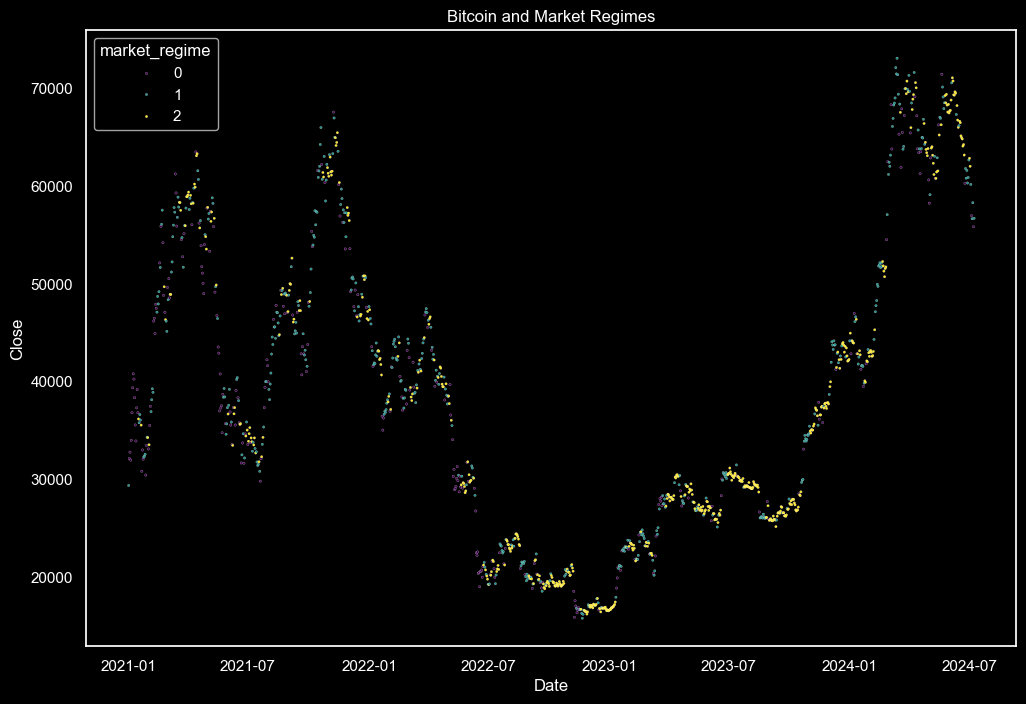

In [137]:
# PLOTTING PREDICTED MARKET REGIMES

testing_data.loc[:, 'market_regime'] = hmm_model.predict(np.array(testing_data[features]))
testing_data.loc[:, 'market_regime'] = hmm_model.predict(np.array(testing_data[features]))

plt.figure(figsize=(12, 8))
sns.scatterplot(x=testing_data.index, y='Close', hue='market_regime', data=testing_data, s=3, palette='viridis')
plt.title('Bitcoin and Market Regimes')
plt.show()

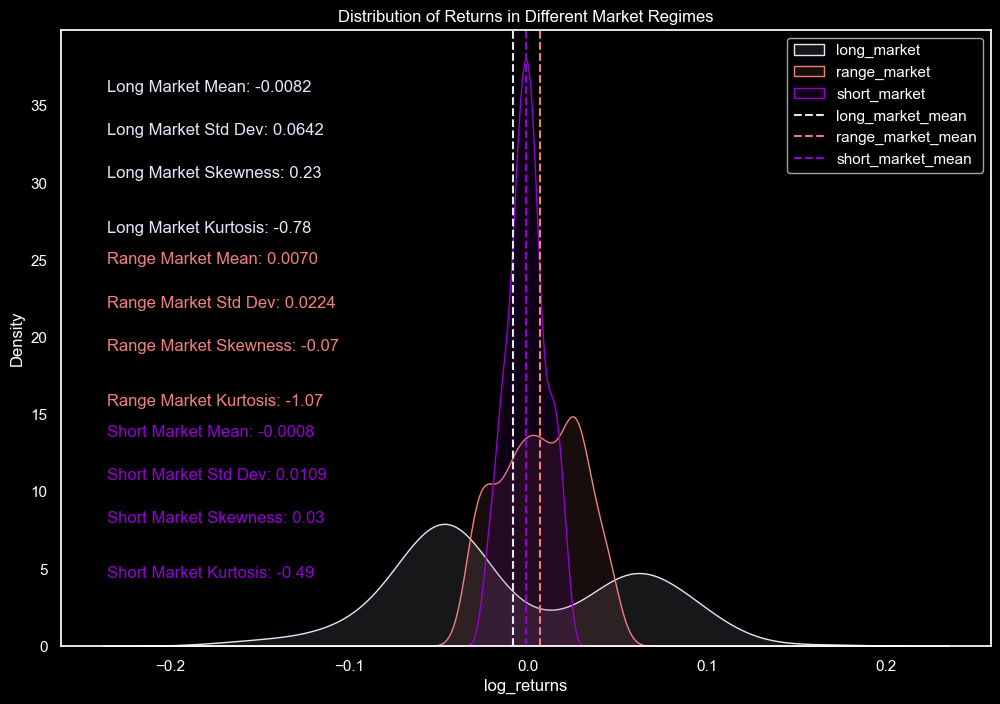

In [138]:
# PLOTTING LOG RETURNS UNDER DIFFERENT PREDICTED MARKET REGIMES

long_market = testing_data[testing_data['market_regime'] == 2]
short_market = testing_data[testing_data['market_regime'] == 0]
range_market = testing_data[testing_data['market_regime'] == 1]

sns.set_theme(style="dark", rc={"axes.grid": False})

plt.style.use('dark_background')

plt.figure(figsize=(12,8))
sns.kdeplot(long_market['log_returns'], label='long_market', color='lavender', fill=True, alpha=0.1)
sns.kdeplot(range_market['log_returns'], label='range_market', color='lightcoral', fill=True, alpha=0.1)
sns.kdeplot(short_market['log_returns'], label='short_market', color='darkviolet', fill=True, alpha=0.1)
plt.axvline(long_market['log_returns'].mean(), color='lavender', linestyle='--', label='long_market_mean')
plt.axvline(range_market['log_returns'].mean(), color='lightcoral', linestyle='--', label='range_market_mean')
plt.axvline(short_market['log_returns'].mean(), color='darkviolet', linestyle='--', label='short_market_mean')

y_cord = 0.90
delt = 0.07
for market, color, label in [(long_market, 'lavender', 'Long'), (range_market, 'lightcoral', 'Range'), (short_market, 'darkviolet', 'Short')]:
    # Computing statistics 
    mean = market['log_returns'].mean()
    std_dev = market['log_returns'].std()
    skewness = skew(market['log_returns'])
    kurt = kurtosis(market['log_returns'])

    plt.annotate(f'{label} Market Mean: {mean:.4f}', xy=(0.05, y_cord), xycoords='axes fraction', color=color)
    y_cord -= delt
    plt.annotate(f'{label} Market Std Dev: {std_dev:.4f}', xy=(0.05, y_cord), xycoords='axes fraction', color=color)
    y_cord -= delt
    
    plt.annotate(f'{label} Market Skewness: {skewness:.2f}', xy=(0.05, y_cord), xycoords='axes fraction', color=color)
    y_cord -= delt
    plt.annotate(f'{label} Market Kurtosis: {kurt:.2f}', xy=(0.05, y_cord), xycoords='axes fraction', color=color, verticalalignment='top')
    y_cord -= delt

plt.legend()
plt.title('Distribution of Returns in Different Market Regimes')

plt.show()

{'Sharpe Ratio': '-0.12', 'Closing capital': '8054.97', 'Max Drawdown': '0.64', 'Calmar Ratio': '-0.09', 'Sortino Ratio': '-0.11', 'VaR 99% 1 Day': '0.00', 'VaR 99% 10 Days': '0.00'}


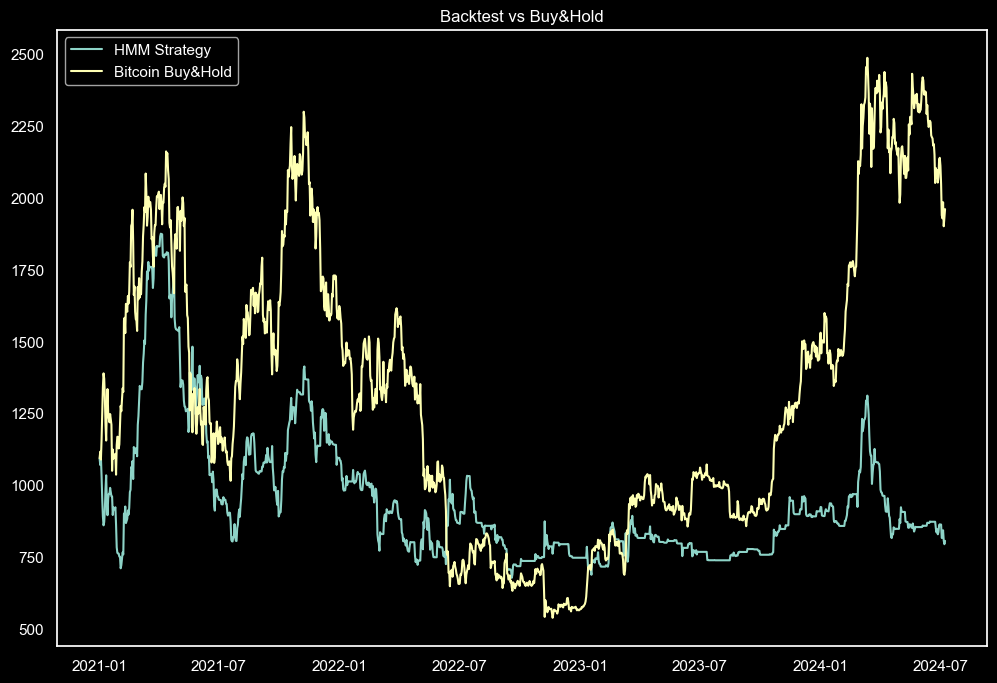

In [139]:
# IMPLEMENTING AND BACKTESTING A SIMPLE TRADING STRATEGY
"""
Our simple strategy will be as followed:
    - taking a long position when our model predicts a bullish market (market_regime = 1)
    - taking a short position when our model predicts a bearish market (market_regime = 0)
    - staying neutral when our model does not predict a clear market trend (market_regime = 2)

We will consider a trading fee of 0.1%, which we will apply at each transaction.
During our backtesting, we will compute returns by multiplying our trading signal (1, -1, 0) 
by the future returns minus the associated fee.
"""

conditions = [
    testing_data['market_regime'] == 2,
    testing_data['market_regime'] == 1,
    testing_data['market_regime'] == 0
]
choices = [
    1,
    0,
    -1
]
fee = 0.001

testing_data['signal'] = np.select(conditions, choices, default=0)
testing_data['shifted_signal'] = testing_data['signal'].shift(1)

# Fee is applied whenever a trading signal at date d is different from a trading signal at date d-1.
testing_data['fee'] = np.where(testing_data['signal'] != testing_data['shifted_signal'], fee, 0)
testing_data['backtest'] = testing_data['forward_returns'] * testing_data['signal'] - testing_data['fee']

# EVALUATING OUR STRATEGY
def computing_portfolio_metrics(resampled_returns, starting_capital=10000):
    # Computing annual parameters
    sigma = resampled_returns.std() * np.sqrt(356)
    mu = resampled_returns.mean() * 356

    # Sharpe ratio - ignoring risk free rate as it is unknown
    sharpe = mu / sigma

    # Evolution of starting capital
    pf = starting_capital * np.exp(resampled_returns).cumprod()

    # max Drawdown
    max_dd = -min(pf / pf.expanding(1).max() - 1)

    # Calmar ratio
    calmar = mu / max_dd

    # Dev. of negative returns
    sigma_neg = np.sqrt(np.mean(resampled_returns[resampled_returns < 0].pow(2))) * np.sqrt(356)

    # Sortino ratio
    sortino = mu / sigma_neg

    # Adjusting distribution of returns with Johnson SU
    a, b, loc, scale = johnsonsu.fit(resampled_returns)

    # Value at Risk 99% 1 day
    alpha_risk = 0.99
    VAR_99_1d = johnsonsu.ppf(1 - alpha_risk, a, b, loc, scale) * starting_capital * -1

    # VaR 10 days
    approx_VAR_99_10d = VAR_99_1d * np.sqrt(10)

    metrics = {
        'Sharpe Ratio': sharpe,
        'Closing capital': pf.iloc[-1],
        'Max Drawdown': max_dd,
        'Calmar Ratio': calmar,
        'Sortino Ratio': sortino,
        'VaR 99% 1 Day': VAR_99_1d,
        'VaR 99% 10 Days': approx_VAR_99_10d
    }

    return {k: f"{v:.2f}" for k, v in metrics.items()}


"""
We obtained the following measurments:
{'Sharpe Ratio': '-0.13', 
'Closing capital': '7829.30', 
'Max Drawdown': '0.64', 
'Calmar Ratio': '-0.11', 
'Sortino Ratio': '-0.13', 
'VaR 99% 1 Day': '1.07', 
'VaR 99% 10 Days': '3.40'}

The Sharpe ratio measured indicates a low return compared to the risk. 
Our max drawdown is high considering a maximum loss of 64% of our capital. 
The Calmar ratio indicates that our strategy is relatively poor in bearish conditions.

Finally, the VaR99 1D and 10D highlight the very high risk associated with our strategy. This can be clearly understood
from our first plot which shows our model's sometimes eratic market regime predictions.

We will continue working on this model to improve its performance as we believe HMM can, even with such a simple strategy,
enable a strong portfolio. The simple modification of our random seed greatly improved performance and we hope to keep finding such 
improvements. 
We will, in the mean time, explore other strategies based on this model.
""" 
print(computing_portfolio_metrics(testing_data['backtest']))


plt.figure(figsize=(12, 8))
plt.title('Backtest vs Buy&Hold')
plt.plot(np.exp(testing_data['backtest'].mul(1)).cumprod().mul(1000), label='HMM Strategy')
plt.plot(np.exp(testing_data['forward_returns'].mul(1)).cumprod().mul(1000), label='Bitcoin Buy&Hold')
plt.legend()
plt.show()
